## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [23]:
# autoreload for modules
%load_ext autoreload
%autoreload 2

# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
import pandas as pd # Used for simpler processing of data
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

## Import Algorithms
from algs import NmfHyperEstimator, NmfL2Estimator, ModifiedNMF, NmfL1Estimator

#Import preprocessing
from preprocessing import SaltNPepper, Gaussian, ImageNormalizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Dataset

### 1.0 Data Folder

In [2]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x 41 Dovermore staff 1312 Oct  6 14:04 CroppedYaleB
drwxr-xr-x 44 Dovermore staff 1408 Oct  6 14:04 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
# Load ORL dataset.
X_orl, Y_orl = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_orl.shape, Y_orl.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


### With scaling the data

In [4]:
#Demonstrate noisy Image
V_hat, Y_hat = load_data(root='data/ORL', reduce=3)
scaler = ImageNormalizer(min=0,max=1)

noise = SaltNPepper(p=0.1, r=0.4) 

V_snp = noise.fit_transform(V_hat)
V_snp = scaler.fit_transform(V_snp)

noise_g = Gaussian(mean=0, sigma=10) 
V_g = noise_g.fit_transform(V_hat)
V_g = scaler.fit_transform(V_g)

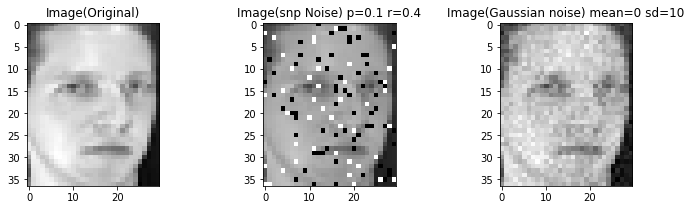

In [95]:
#Plot result.
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0 sd=10')
plt.draw()
plt.savefig("noisyImage", dpi=100)
plt.show()

In [86]:
#Image Reconstruction
#Using Hypersurface
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50) # set n_components to num_classes.
#Salt n Pepper
H = nmf_hyper.fit_transform(V_snp)
W = nmf_hyper.components_
V_snp_reconstructed_hyper = W @ H
#Gaussian
H = nmf_hyper.fit_transform(V_g)
V_g_reconstructed_hyper = W @ H

#Using L2NMF
np.random.seed(0)
nmf_L2 = NmfL2Estimator(n_components=50) # set n_components to num_classes.
#SaltNPepper
H = nmf_L2.fit_transform(V_snp)
W = nmf_L2.components_
V_snp_reconstructed_L2 = W @ H
#Gaussian
H = nmf_L2.fit_transform(V_g)
V_g_reconstructed_L2 = W @ H

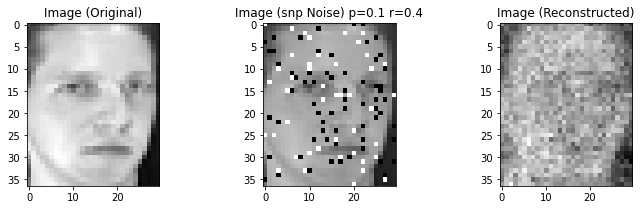

In [87]:
#Reconstruction (snp noise) using hyper
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_snp.png", dpi=100)

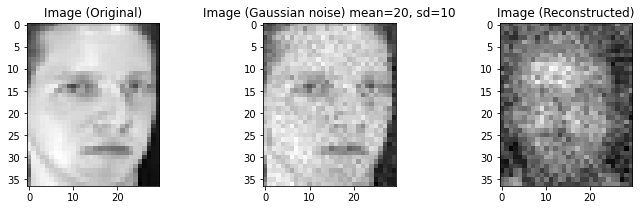

In [88]:
#Reconstruction (Gaussian noise) using hyper
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_gaussian", dpi=100)

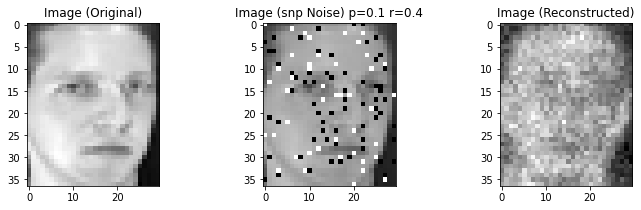

In [89]:
#Reconstruction (snp noise) using L2NMF
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_snp", dpi=100)

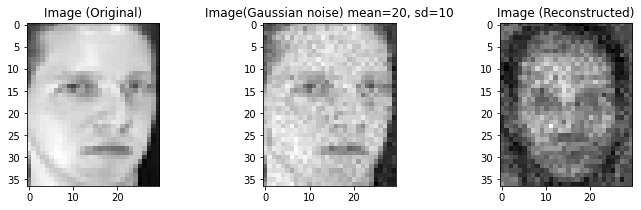

In [90]:
#Reconstruction (Gaussian noise) using L2NMF
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_gaussian", dpi=100)

### Without scaling the data

In [96]:
V_hat, Y_hat = load_data(root='data/ORL', reduce=3)
scaler = ImageNormalizer(min=None,max=None)

noise = SaltNPepper(p=0.1, r=0.4) 
noise_g = Gaussian(mean=0, sigma=10)

V_snp = noise.fit_transform(V_hat)
V_snp = scaler.fit_transform(V_snp)

V_g = noise_g.fit_transform(V_hat)
V_g = scaler.fit_transform(V_g)

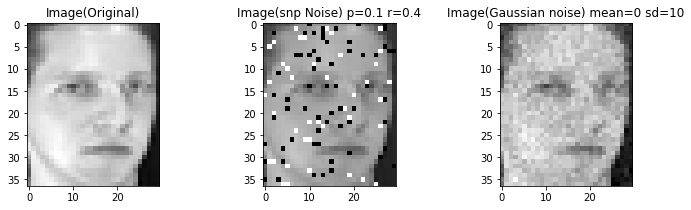

In [97]:
#Plot result.
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0 sd=10')
plt.draw()
plt.savefig("noisyImage", dpi=100)
plt.show()

In [99]:
#Using Hypersurface
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50) # set n_components to num_classes.
#Salt n Pepper
H = nmf_hyper.fit_transform(V_snp)
W = nmf_hyper.components_
V_snp_reconstructed_hyper = W @ H
#Gaussian
H = nmf_hyper.fit_transform(V_g)
V_g_reconstructed_hyper = W @ H

#Using L2NMF
np.random.seed(0)
nmf_L2 = NmfL2Estimator(n_components=50) # set n_components to num_classes.
#SaltNPepper
H = nmf_L2.fit_transform(V_snp)
W = nmf_L2.components_
V_snp_reconstructed_L2 = W @ H
#Gaussian
H = nmf_L2.fit_transform(V_g)
V_g_reconstructed_L2 = W @ H

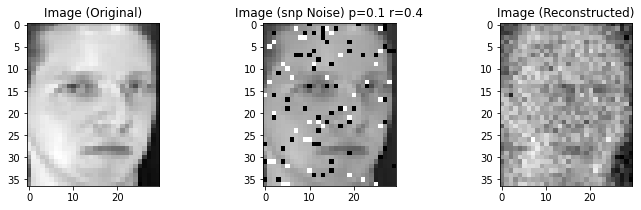

In [101]:
#Reconstruction (snp noise) using hyper
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_snp.png", dpi=100)

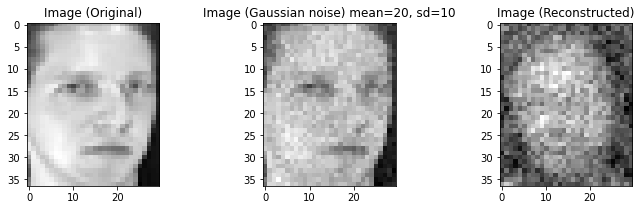

In [102]:
#Reconstruction (Gaussian noise) using hyper
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_gaussian", dpi=100)

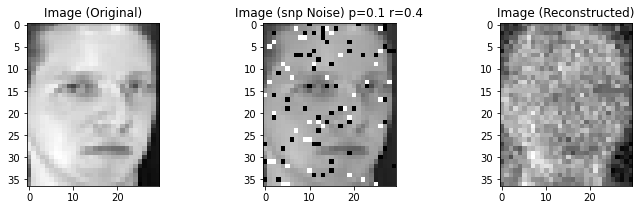

In [103]:
#Reconstruction (snp noise) using L2NMF
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_snp", dpi=100)

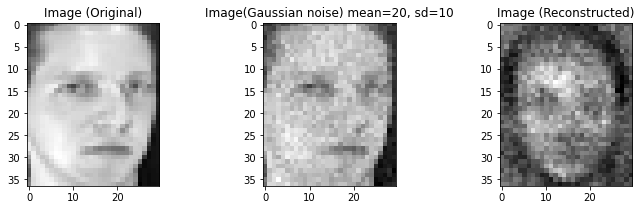

In [104]:
#Reconstruction (Gaussian noise) using L2NMF
img_size = [i//3 for i in (90, 111)] #ORL
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_gaussian", dpi=100)

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

## Performance comparison (with scaling) with 40% samples

In [24]:
X, Y, scaler = X_orl, Y_orl, ImageNormalizer(min=None,max=None)
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL1Estimator,
    NmfL2Estimator,
    NmfHyperEstimator#, {"max_armijo": 2, "alpha0": 0.3, "beta0": 0.5, "init": 'random'}] # disable armijo search
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3         #No of random samples considered for training
pc_sample = 0.4      #Training with 40% data

In [25]:
#Saltnpepper noise
all_n_components = range(30, 60, 20)
noise_alg = SaltNPepper
noise_levels = np.arange(0, 0.5, 0.1)
ratios = [0.5] #np.arange(0.0, 1, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.0, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 1, 'p': 0.1, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL1Estimator {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 2, 'p': 0.2, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        

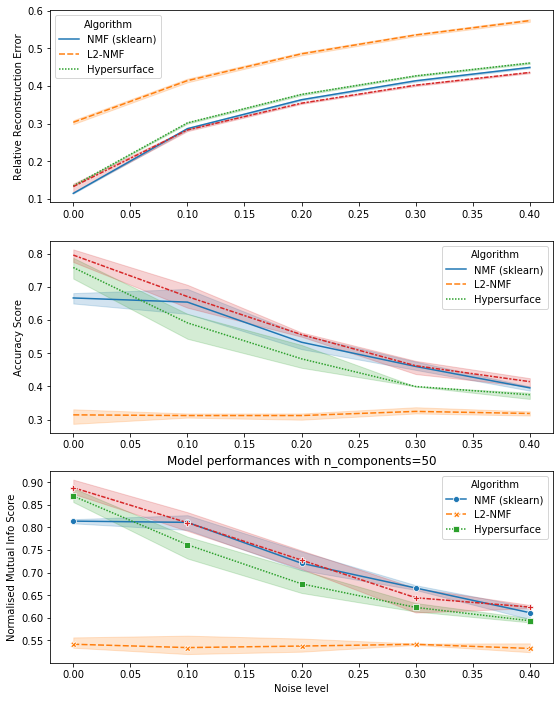

In [26]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    #legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    ci=95,
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.title("Model performances with n_components=50")
plt.savefig("snp_scaled_40%_new")

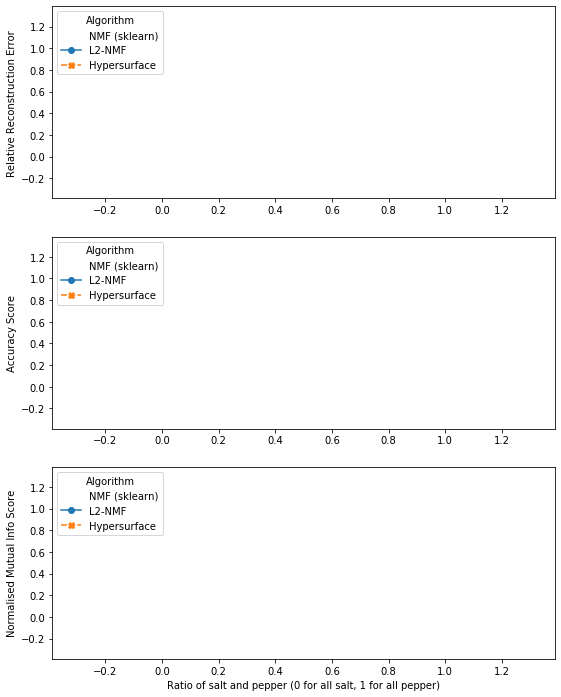

In [28]:
# Measuring RRE, Accuracy and NMI scores vs salt and pepper ratio for n_components=30 and noise at 0.1
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="ratio",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and p==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="ratio",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and p==0.1"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="ratio",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and p==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band'
)
ax.set_xlabel("Ratio of salt and pepper (0 for all salt, 1 for all pepper)")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("fig2_new")

In [15]:
# Gaussian noise
X, Y, scaler = X_orl, Y_orl, ImageNormalizer(min=None,max=None)
noise_alg = Gaussian
means = [0]
sigmas = list(range(0, 25, 5))
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, mean=means, sigma=sigmas)

evaluations_g = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'mean': 0, 'sigma': 0}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 1, 'mean': 0, 'sigma': 5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 2, 'mean': 0, 'sigma': 10}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2


In [16]:
(evaluations_g.query("alg == 'NmfHyperEstimator' and n_components == 100")# and ratio==0.5")
 .sort_values(["rre"]))#, "acc_score"]))

,alg,n_components,kwargs,noise_id,noise_level,ratio,trial_id,rre,acc_score,nmi_score,mean,sigma


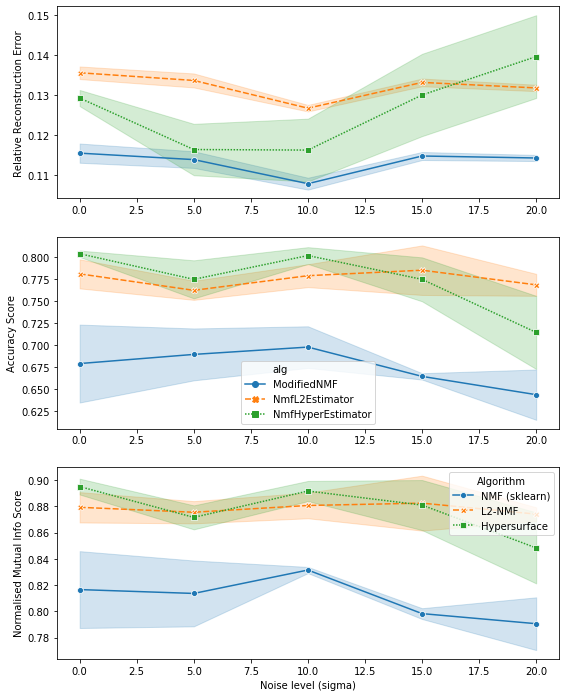

In [17]:
# Plotting RRE, Accuracy and NMI scores against different Gaussian noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="sigma",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    markers=True,
    sort=True,
    err_style='band',
    legend=False,
)
ax.set_xlabel('')
#ax.legend(title="Algorithm", loc="bottom right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
ax.set_ylabel("Relative Reconstruction Error")

ax = fig.add_subplot(312)
sns.lineplot(
    x="sigma",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
#ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="sigma",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level (sigma)")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("Gaussian_ORL_normalised_40%_new")

In [ ]:
DataFrame.to_latex

## Performance comparison (without scaling) with 40% samples

In [18]:
X, Y, scaler = X_orl, Y_orl, ImageNormalizer(min=0, max=1)
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator,
    NmfHyperEstimator
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3         #No of random samples considered for training
pc_sample = 0.4      #Training with 40% data

In [20]:
#Saltnpepper noise
all_n_components = range(30, 60, 20)
noise_alg = SaltNPepper
noise_levels = np.arange(0, 0.5, 0.1)
ratios = [0.5] #np.arange(0.0, 1, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations_noScale = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.0, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 1, 'p': 0.1, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 2, 'p': 0.2, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}
        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Al

In [21]:
# Simple check for scores
(evaluations_noScale.query("alg == 'NmfHyperEstimator' and n_components == 30 and r==0.5")
 .sort_values(["rre"]))#, "acc_score"]))

evaluations.query("n_components==30 and ratio==0.5")

,alg,n_components,kwargs,noise_id,noise_level,ratio,trial_id,rre,acc_score,nmi_score,p,r


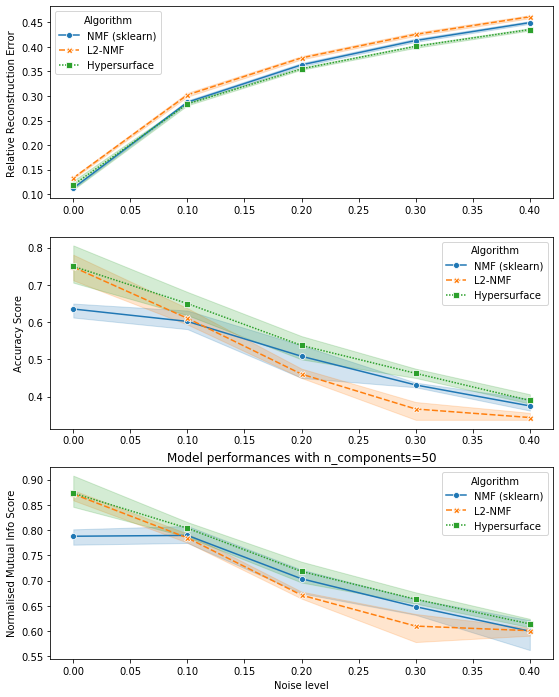

In [22]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_noScale.query("n_components == 50"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    #legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_noScale.query("n_components == 50"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_noScale.query("n_components == 50"),
    estimator='mean',
    ci=95,
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.title("Model performances with n_components=50")
plt.savefig("snp_noScale_40%_new")

## Performance comparison (with scaling) with 90% samples

In [125]:
X, Y, scaler = X_orl, Y_orl, ImageNormalizer(min=None,max=None)
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator,
    NmfHyperEstimator
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3         #No of random samples considered for training
pc_sample = 0.9      #Training with 90% data

NameError: name 'NmfHyperEstimato' is not defined

In [126]:
#Saltnpepper noise
all_n_components = [50]
noise_alg = SaltNPepper
noise_levels = np.arange(0, 0.5, 0.1)
ratios = [0.5] #np.arange(0.0, 1, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations_90_snp = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.0, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 1, 'p': 0.1, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 2, 'p': 0.2, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 3, 'p': 0.30000000000000004, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
Noise: {'noise_id': 4, 'p': 0.4, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {}


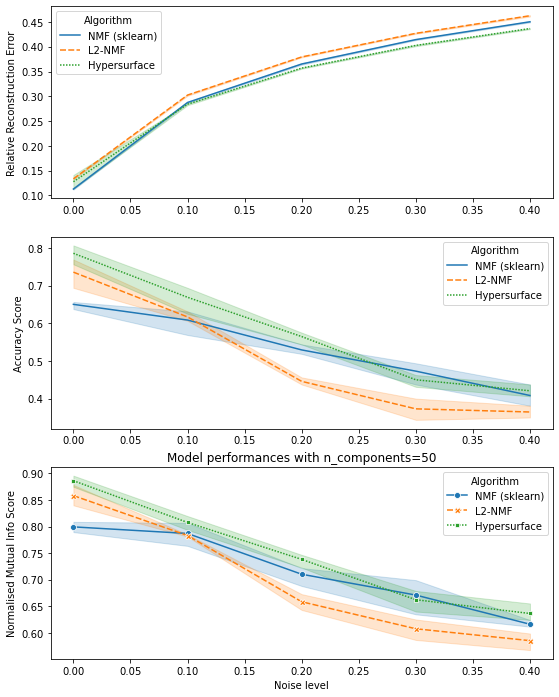

In [127]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_90_snp.query("n_components == 50"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    #legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_90_snp.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    ci=95,
    n_boot=1000,
    markers=True,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_90_snp.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    ci=95,
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper right", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.title("Model performances with n_components=50")
plt.savefig("snp_scaled_90%")

In [130]:
(evaluations_90_snp.query("n_components == 50")# and ratio==0.5")
 .sort_values(["rre"]))#, "acc_score"]))

,alg,n_components,kwargs,noise_id,noise_level,ratio,trial_id,rre,acc_score,nmi_score,p,r
0,ModifiedNMF,50,{},0,NaN,NaN,0,0.111690,0.63750,0.799725,0.0,0.5
3,ModifiedNMF,50,{},0,NaN,NaN,1,0.113261,0.65625,0.808724,0.0,0.5
2,NmfHyperEstimator,50,{},0,NaN,NaN,0,0.113488,0.80625,0.895614,0.0,0.5
6,ModifiedNMF,50,{},0,NaN,NaN,2,0.113603,0.65625,0.789539,0.0,0.5
8,NmfHyperEstimator,50,{},0,NaN,NaN,2,0.128044,0.79375,0.888017,0.0,0.5
1,NmfL2Estimator,50,{},0,NaN,NaN,0,0.132284,0.76875,0.878129,0.0,0.5
7,NmfL2Estimator,50,{},0,NaN,NaN,2,0.133660,0.74375,0.856337,0.0,0.5
4,NmfL2Estimator,50,{},0,NaN,NaN,1,0.134484,0.69375,0.839851,0.0,0.5
5,NmfHyperEstimator,50,{},0,NaN,NaN,1,0.141238,0.75625,0.874675,0.0,0.5
14,NmfHyperEstimator,50,{},1,NaN,NaN,1,0.282035,0.62500,0.793642,0.1,0.5
